In [24]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import os
import pickle
from scipy.stats import ttest_rel
from sklearn.decomposition import PCA
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torchmetrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool



In [2]:
train_folder = 'data/train'
test_folder = 'data/test'

def convert_sample(path):
    return np.load(os.path.join(path,'fnc.npy')), np.load(os.path.join(path,'icn_tc.npy'))


def get_train_set():
    fnc_list = []
    icn_tc_list = []
    targets = []
    for folder in os.listdir(train_folder):
        for sample in os.listdir(os.path.join(train_folder,folder)):
            fnc, icn_tc = convert_sample(os.path.join(train_folder,folder,sample))
            fnc_list.append(torch.tensor(fnc.reshape(5460), dtype=torch.float32))
            icn_tc_list.append(torch.tensor(icn_tc, dtype=torch.float32))
            targets.append(torch.tensor([1 if folder=="BP" else 0 ], dtype=torch.float32))

    return fnc_list, icn_tc_list, targets

def get_data_set():
    data_set = []
    for folder in os.listdir(train_folder):
        for sample in os.listdir(os.path.join(train_folder,folder)):
            fnc, icn_tc = convert_sample(os.path.join(train_folder,folder,sample))
            target = torch.tensor([1 if folder=="BP" else 0 ], dtype=torch.float32)
            data_set.append((torch.tensor(fnc.reshape(5460), dtype=torch.float32), target))

    return data_set

def get_icn_data():
    data_set = []
    for folder in os.listdir(train_folder):
        for sample in os.listdir(os.path.join(train_folder,folder)):
            fnc, icn_tc = convert_sample(os.path.join(train_folder,folder,sample))
            target = torch.tensor([1 if folder=="BP" else 0 ], dtype=torch.float32)
            data_set.append(torch.tensor(icn_tc, dtype=torch.float32))

    return data_set

def get_test_set():
    fnc_list = []
    icn_tc_list = []
    names = []
    for folder in os.listdir(test_folder):
        fnc, icn_tc = convert_sample(os.path.join(test_folder,folder))
        fnc_list.append(fnc.reshape(5460))
        icn_tc_list.append(icn_tc)
        names.append(folder)
        
    return fnc_list, icn_tc_list, names



In [3]:
fnc_data, icn_data, targets = get_train_set()

In [5]:
def convert_to_fnc_matrix(fnc, matrix_size=105):
    """
    Converts the upper triangular part of the input array into a symmetric matrix.

    Parameters:
    - data: tuple (array, target), where array is the upper triangular part of the matrix.
    - matrix_size: int, the size of the square matrix.

    Returns:
    - symmetric_matrix: numpy.ndarray, the reconstructed symmetric matrix.
    """
    upper_triangular = fnc.numpy()
    matrix = np.zeros((matrix_size, matrix_size))
    matrix[np.triu_indices(matrix_size, k=1)] = np.abs(upper_triangular)
    matrix += matrix.T
    return torch.tensor(matrix, dtype=torch.float32)

def convert_to_adjency_matrix(fnc_matrix, percentile):
    matrix = fnc_matrix.numpy()
    threshold = np.percentile(matrix[matrix > 0], percentile)
    matrix = np.where(matrix<threshold, 0, 1)
    return torch.tensor(matrix, dtype=torch.float32)

def convert_to_edge_index(adj_matrix):
    edge_index = torch.nonzero(adj_matrix).T
    return edge_index



fnc_matricies = [convert_to_fnc_matrix(fnc) for fnc in fnc_data]
adj_matricies = [convert_to_adjency_matrix(fnc_matrix, 90) for fnc_matrix in fnc_matricies]
edge_indicies = [convert_to_edge_index(adj_matrix) for adj_matrix in adj_matricies]


# Use PCA to extract node features from icn_data
node_features = []
for icn in icn_data:
    icn_flat = icn.reshape(-1, icn.shape[-1]) if icn.ndim > 1 else icn.reshape(1, -1)
    pca = PCA(n_components=30)
    pcs = pca.fit_transform(icn_flat.T)
    node_features.append(torch.tensor(pcs, dtype=torch.float32))

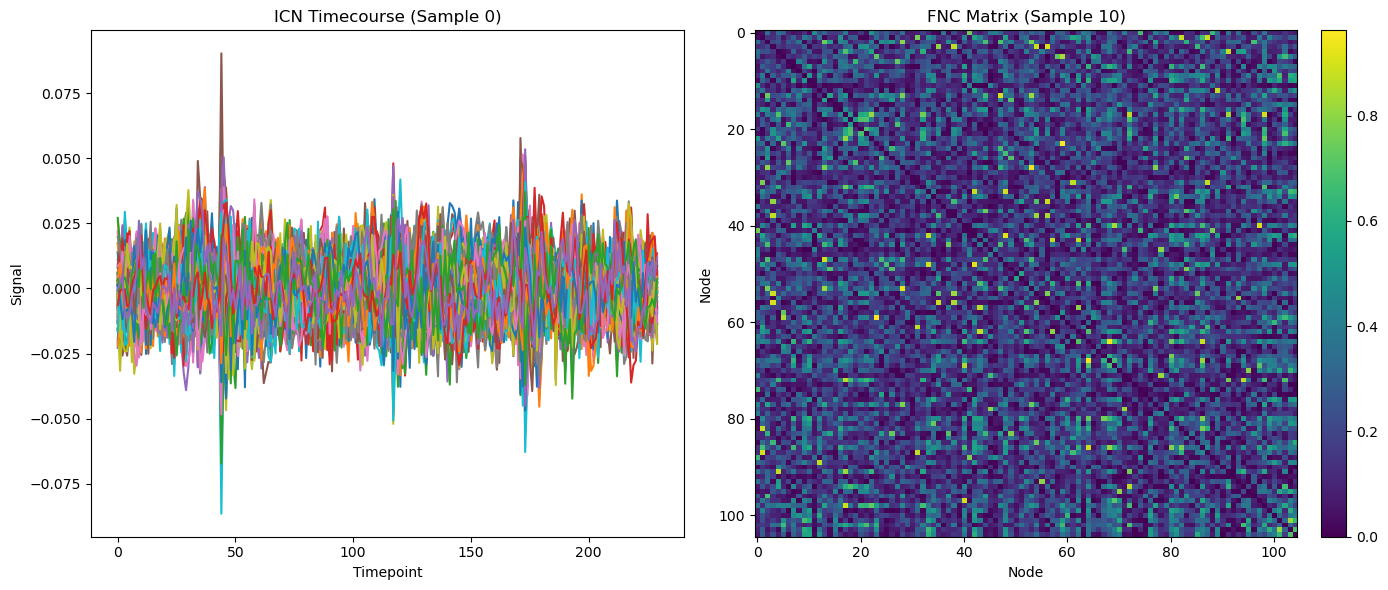

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

i = 10

# Plot ICN timecourse
axs[0].plot(icn_data[i])
axs[0].set_title("ICN Timecourse (Sample 0)")
axs[0].set_xlabel("Timepoint")
axs[0].set_ylabel("Signal")

# Plot FNC matrix
im = axs[1].imshow(fnc_matricies[i], aspect='auto', cmap='viridis')
axs[1].set_title(f"FNC Matrix (Sample {i})")
axs[1].set_xlabel("Node")
axs[1].set_ylabel("Node")
plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

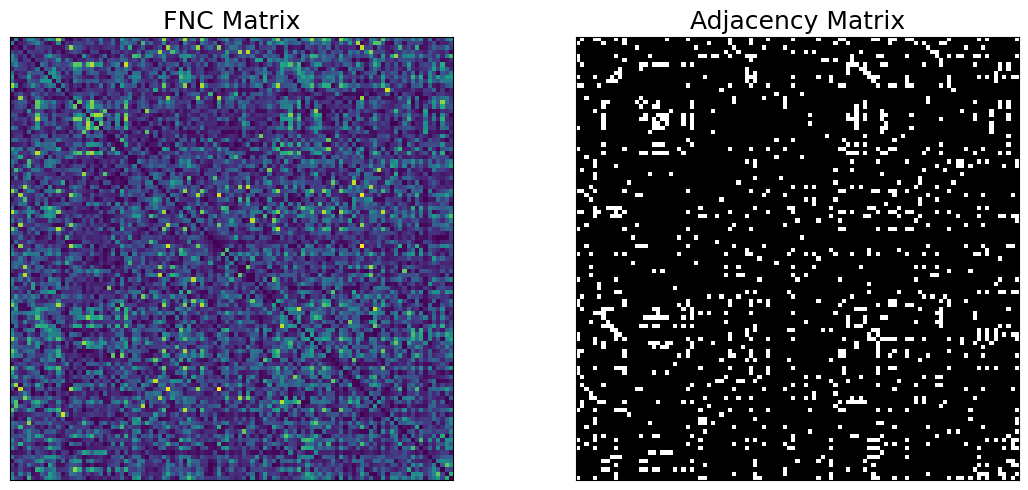

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(fnc_matricies[0])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title("FNC Matrix", size=18)

axs[1].imshow(adj_matricies[0], cmap='gray')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Adjacency Matrix", size=18)

plt.tight_layout(w_pad=0.005)  # Reduce horizontal padding
plt.show()

In [9]:
pos_weight = (len(targets)-np.count_nonzero(targets))/np.count_nonzero(targets)
pos_weight

1.5737704918032787

In [10]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [11]:

graph_data = []
for i in range(len(targets)):
    node_feature = node_features[i]
    edge_index = edge_indicies[i]
    target = targets[i]
    data = Data(x=node_feature, edge_index=edge_index, y=target)
    graph_data.append(data)



mlp_data = []
for fnc, target in zip(fnc_data, targets):
    mlp_data.append((fnc, target))


In [13]:
def get_metrics(model, loader):
    model.eval()

    metric_acc = torchmetrics.classification.BinaryAccuracy()
    metric_f1 = torchmetrics.classification.BinaryF1Score()
    metric_auc = torchmetrics.classification.BinaryAUROC()
    metric_sens = torchmetrics.classification.BinaryRecall()  # Sensitivity = Recall
    metric_spec = torchmetrics.classification.BinarySpecificity()
    metric_precision = torchmetrics.classification.BinaryPrecision()
    all_preds = []
    all_targets = []
    model.eval()

    for data in loader:
        if len(data) == 2:
            fnc = data[0]
            target = data[1]
            preds = model(fnc)
            all_preds.append(preds.detach())
            all_targets.append(target.detach())

        else:
            preds = model(data.x, data.edge_index, data.batch)
            all_preds.append(preds.detach())
            all_targets.append(data.y.detach())


    all_preds = torch.cat(all_preds).view(-1)
    all_targets = torch.cat(all_targets).view(-1)
    acc = metric_acc(all_preds, all_targets.int()).item()
    f1 = metric_f1(all_preds, all_targets.int()).item()
    auc = metric_auc(all_preds, all_targets.int()).item()
    sens = metric_sens(all_preds, all_targets.int()).item()
    spec = metric_spec(all_preds, all_targets.int()).item()
    precision = metric_precision(all_preds, all_targets.int()).item()
    return acc, f1, auc, sens, spec, precision

In [14]:
class MLP(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.layer1 = nn.Linear(in_features, 512)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 512)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(512, 64)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout(x)
        x = self.act2(self.layer2(x))
        x = self.dropout(x)
        x = self.act3(self.layer3(x))
        x = self.dropout(x)  
        if self.training:
            x = self.output(x)
        elif not self.training:
            x = self.output(x)
            x = self.sigmoid(x)
        return x

In [15]:
mlp_train, mlp_test = train_test_split(mlp_data, test_size=0.2, stratify=targets)
mlp_train_loader = DataLoader(mlp_train, batch_size=32, shuffle=True)
mlp_test_loader = DataLoader(mlp_test, batch_size=32, shuffle=False)

In [16]:
mlp_model = MLP(5460)
print(mlp_model)

MLP(
  (layer1): Linear(in_features=5460, out_features=512, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=512, out_features=512, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=512, out_features=64, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [17]:
def model_train(model, train_loader):
    model.train()
    
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, dtype=torch.float32))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for fnc, target in train_loader:
        y_pred = model(fnc)
        loss = loss_fn(y_pred, target)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()


def test(model, loader):
    model.eval()

    correct = 0
    for fnc, target in loader:  
       y_pred = model(fnc)  
       correct += int((y_pred.round() == target).sum())  
    return correct / len(loader.dataset)  

train_acc_list = []
test_acc_list = []
epochs = 21
for epoch in range(0, epochs):
    model_train(mlp_model, mlp_train_loader)
    train_acc = test(mlp_model, mlp_train_loader)
    test_acc = test(mlp_model, mlp_test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    acc, f1, auc, sens, spec, precision = get_metrics(mlp_model, mlp_test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    print(f'Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}, Sens: {sens:.4f}, Spec: {spec:.4f}, Precision: {precision:.4f}')

Epoch: 000, Train Acc: 0.6463, Test Acc: 0.6105
Acc: 0.6105, F1: 0.0000, AUC: 0.5951, Sens: 0.0000, Spec: 1.0000, Precision: 0.0000
Epoch: 001, Train Acc: 0.6117, Test Acc: 0.6105
Acc: 0.6105, F1: 0.0000, AUC: 0.5722, Sens: 0.0000, Spec: 1.0000, Precision: 0.0000
Epoch: 002, Train Acc: 0.6410, Test Acc: 0.5158
Acc: 0.5158, F1: 0.5490, AUC: 0.5499, Sens: 0.7568, Spec: 0.3621, Precision: 0.4308
Epoch: 003, Train Acc: 0.7021, Test Acc: 0.5474
Acc: 0.5474, F1: 0.5057, AUC: 0.5494, Sens: 0.5946, Spec: 0.5172, Precision: 0.4400
Epoch: 004, Train Acc: 0.6968, Test Acc: 0.5684
Acc: 0.5684, F1: 0.5495, AUC: 0.5848, Sens: 0.6757, Spec: 0.5000, Precision: 0.4630
Epoch: 005, Train Acc: 0.8165, Test Acc: 0.6316
Acc: 0.6316, F1: 0.4615, AUC: 0.6002, Sens: 0.4054, Spec: 0.7759, Precision: 0.5357
Epoch: 006, Train Acc: 0.8191, Test Acc: 0.6000
Acc: 0.6000, F1: 0.5250, AUC: 0.6356, Sens: 0.5676, Spec: 0.6207, Precision: 0.4884
Epoch: 007, Train Acc: 0.8617, Test Acc: 0.5895
Acc: 0.5895, F1: 0.4507, AUC

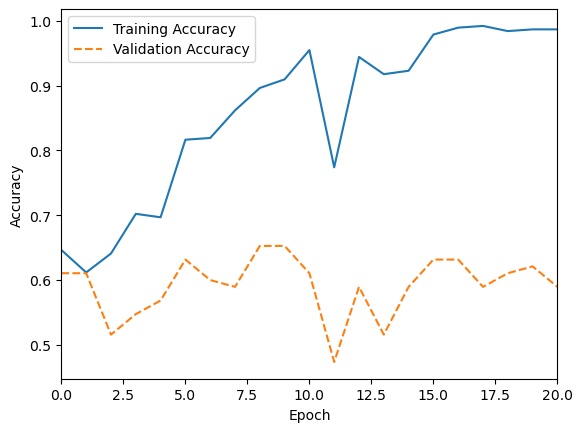

In [19]:
def plot_training(epochs, train_losses, val_losses):
    """Plot the training and validation losses."""
    plt.plot(range(epochs), train_losses, label="Training Accuracy")
    plt.plot(range(epochs), val_losses, "--", label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.xlim([0, epochs - 1])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_training(epochs, train_acc_list, test_acc_list)

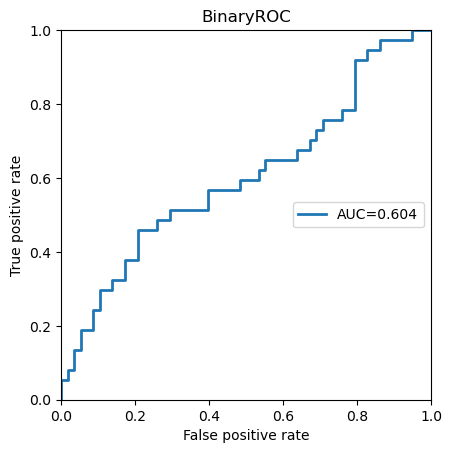

In [21]:
def plot_roc(model, loader, model_name="MLP"):
    model.eval()
    """Plot ROC curve."""
    roc = torchmetrics.ROC(task="binary")
    if model_name == "MLP":
        for fnc, target in loader:
            roc.update(model(fnc), target.long())
    elif model_name == "GCN":
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            roc.update(out, data.y.unsqueeze(-1).long())
    else:
        raise ValueError("Unknown model name")

    fig, ax = roc.plot(score=True)
    ax.grid(False)
    ax.axis("square")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc="center right")
    plt.show()

plot_roc(mlp_model, mlp_test_loader)

In [23]:

def get_confusion_matrix(model, loader,model_name="MLP"):
    all_preds = []
    all_targets = []
    model.eval()
    for data in loader:
        if model_name == "MLP":
            fnc = data[0]
            target = data[1]
            preds = model(fnc)
            all_preds.append(preds.detach().cpu())
            all_targets.append(target.detach().cpu())
        else:
            preds = model(data.x, data.edge_index, data.batch)
            all_preds.append(preds.detach().cpu())
            all_targets.append(data.y.unsqueeze(-1).detach().cpu())

    all_preds = torch.cat(all_preds).view(-1)
    all_targets = torch.cat(all_targets).view(-1)

    # Binarize predictions at 0.5 threshold
    y_pred = (all_preds > 0.5).int().numpy()
    y_true = all_targets.int().numpy()

    cm = confusion_matrix(y_true, y_pred)
    return cm
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SZ','BP'])
    # disp.plot(cmap='Blues', colorbar=False)
    # plt.show()

mlp_confusion_matrix = get_confusion_matrix(mlp_model, mlp_test_loader)

In [25]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.dense_top = nn.Sequential(
            nn.Linear(hidden_channels*2, hidden_channels*2 // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels*2 // 2, hidden_channels*2 // 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels*2 // 4,  1),
        )

    def readout(self, x, batch):
        # 1. Global mean pooling
        x1 = global_mean_pool(x, batch)
        # 2. Global max pooling
        x2 = global_max_pool(x, batch)
        # 3. Concatenate
        x = torch.cat((x1, x2), dim=1)
        return x

        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x1 = self.readout(x, batch)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x2 = self.readout(x, batch)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x3 = self.readout(x, batch)
        

        # 2. Readout layer
        x = x1 + x2 + x3

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.dense_top(x)

        if self.training:
            x = x
        elif not self.training:
            x = x.sigmoid()
        
        return x

In [26]:
graph_model = GCN(hidden_channels=128, num_node_features=30)
print(graph_model)

GCN(
  (conv1): GCNConv(30, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (dense_top): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [27]:
graph_train, graph_test = train_test_split(graph_data, test_size=0.2)
graph_train_loader = DataLoader(graph_train, batch_size=32, shuffle=True)
graph_test_loader = DataLoader(graph_test, batch_size=32, shuffle=False)

In [28]:
graph_model = GCN(hidden_channels=128, num_node_features=30).to(device)


def train_GCN(model, train_loader):
    model.train()
    

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, dtype=torch.float32))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for data in train_loader:
        y_pred = model(data.x, data.edge_index, data.batch)
        
        optimizer.zero_grad()

        loss = loss_fn(y_pred, data.y.unsqueeze(-1))
        loss.backward()
        # update weights
        optimizer.step()


def test_GCN(model, loader):
    model.eval()

    correct = 0
    for data in loader: 
       y_pred = model(data.x, data.edge_index, data.batch) 
       correct += int((y_pred.round() == data.y.unsqueeze(-1)).sum())  
    return correct / len(loader.dataset) 

train_acc_list = []
test_acc_list = []
epochs = 41
for epoch in range(0, epochs):
    train_GCN(graph_model, graph_train_loader)
    train_acc = test_GCN(graph_model, graph_train_loader)
    test_acc = test_GCN(graph_model, graph_test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    acc, f1, auc, sens, spec, precision = get_metrics(graph_model, graph_test_loader)

    if epoch % 1 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        print(f"Precision: {precision:.4f}, Recall: {sens:.4f}, F1: {f1:.4f}")

Epoch: 000, Train Acc: 0.4441, Test Acc: 0.3895
Precision: 0.3056, Recall: 0.7333, F1: 0.4314
Epoch: 001, Train Acc: 0.5053, Test Acc: 0.4211
Precision: 0.2549, Recall: 0.4333, F1: 0.3210
Epoch: 002, Train Acc: 0.4441, Test Acc: 0.3895
Precision: 0.3056, Recall: 0.7333, F1: 0.4314
Epoch: 003, Train Acc: 0.4761, Test Acc: 0.4421
Precision: 0.3231, Recall: 0.7000, F1: 0.4421
Epoch: 004, Train Acc: 0.5957, Test Acc: 0.6105
Precision: 0.3478, Recall: 0.2667, F1: 0.3019
Epoch: 005, Train Acc: 0.4362, Test Acc: 0.3895
Precision: 0.3056, Recall: 0.7333, F1: 0.4314
Epoch: 006, Train Acc: 0.5718, Test Acc: 0.4316
Precision: 0.2857, Recall: 0.5333, F1: 0.3721
Epoch: 007, Train Acc: 0.4628, Test Acc: 0.4000
Precision: 0.3448, Recall: 1.0000, F1: 0.5128
Epoch: 008, Train Acc: 0.4761, Test Acc: 0.4000
Precision: 0.3448, Recall: 1.0000, F1: 0.5128
Epoch: 009, Train Acc: 0.4628, Test Acc: 0.4000
Precision: 0.3448, Recall: 1.0000, F1: 0.5128
Epoch: 010, Train Acc: 0.5452, Test Acc: 0.4316
Precision: 0

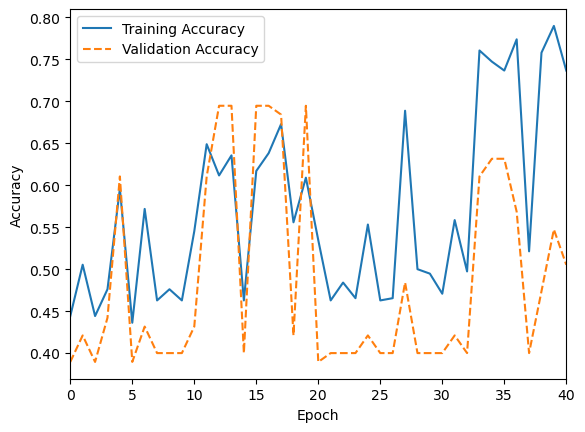

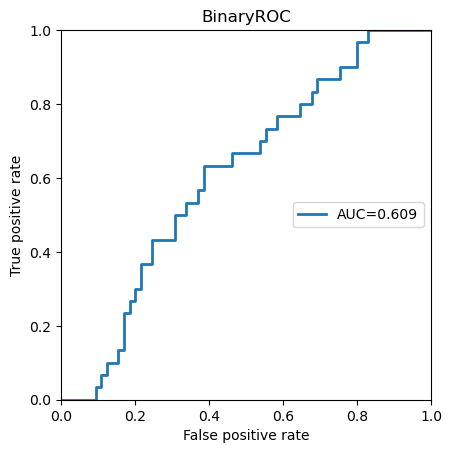

In [29]:
plot_training(epochs, train_acc_list, test_acc_list)
plot_roc(graph_model, graph_test_loader, 'GCN')

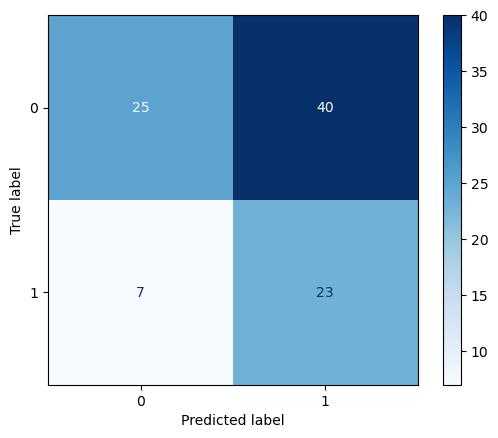

In [30]:
# Collect all predictions and targets from the test loader
all_preds = []
all_targets = []
graph_model.eval()
for data in graph_test_loader:
    preds = graph_model(data.x, data.edge_index, data.batch)
    all_preds.append(preds.detach().cpu())
    all_targets.append(data.y.unsqueeze(-1).detach().cpu())

all_preds = torch.cat(all_preds).view(-1)
all_targets = torch.cat(all_targets).view(-1)

# Binarize predictions at 0.5 threshold
y_pred = (all_preds > 0.5).int().numpy()
y_true = all_targets.int().numpy()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [31]:
import pickle

MLP_dict = {
    "test_acc_list": [],
    "test_F1_list": [],
    "test_auc_list": [],
    "test_sens_list": [],
    "test_spec_list": [],
    "test_precision_list": [],
    "train_acc_list": [],
}    

GCN_dict = {
    "test_acc_list": [],
    "test_F1_list": [],
    "test_auc_list": [],
    "test_sens_list": [],
    "test_spec_list": [],
    "test_precision_list": [],
    "train_acc_list": [],
}


niterations = 1 #200
MLP_epochs = 21
GCN_epochs = 41

for i in range(niterations):
    print(f"Iteration {i+1}/{niterations}")
    mlp_model = MLP(5460)
    GCN_model = GCN(hidden_channels=128, num_node_features=30)


    
    random_state = np.random.RandomState()

    mlp_train, mlp_test = train_test_split(
        mlp_data, test_size=0.2, stratify=targets, shuffle=True, random_state=random_state
    )
    GCN_train, GCN_test = train_test_split(
        graph_data, test_size=0.2, stratify=targets, shuffle=True, random_state=random_state
    )

    mlp_train_loader = DataLoader(mlp_train, batch_size=32, shuffle=True)
    mlp_test_loader = DataLoader(mlp_test, batch_size=32, shuffle=False)

    graph_train_loader = DataLoader(GCN_train, batch_size=32, shuffle=True)
    graph_test_loader = DataLoader(GCN_test, batch_size=32, shuffle=False)


    for epoch in range(0, MLP_epochs):
        model_train(mlp_model, mlp_train_loader)

    for epoch in range(0, GCN_epochs):
        train_GCN(GCN_model, graph_train_loader)

    train_acc = test(mlp_model, mlp_train_loader)
    acc, f1, auc, sens, spec, precision = get_metrics(mlp_model, mlp_test_loader)

    MLP_dict["test_acc_list"].append(acc)
    MLP_dict["test_F1_list"].append(f1)
    MLP_dict["test_auc_list"].append(auc)
    MLP_dict["test_sens_list"].append(sens)
    MLP_dict["test_spec_list"].append(spec)
    MLP_dict["test_precision_list"].append(precision)
    MLP_dict["train_acc_list"].append(train_acc)

    train_acc = test_GCN(GCN_model, graph_train_loader)
    acc, f1, auc, sens, spec, precision = get_metrics(GCN_model, graph_test_loader)
    GCN_dict["test_acc_list"].append(acc)
    GCN_dict["test_F1_list"].append(f1)
    GCN_dict["test_auc_list"].append(auc)
    GCN_dict["test_sens_list"].append(sens)
    GCN_dict["test_spec_list"].append(spec)
    GCN_dict["test_precision_list"].append(precision)
    GCN_dict["train_acc_list"].append(train_acc)



def print_mean_results(results_dict, name):
    print(f"\n{name} mean results over {niterations} iterations:")
    for key, values in results_dict.items():
        if len(values) > 0:
            print(f"{key}: {np.mean(values):.4f} ± {np.std(values):.4f}")

print_mean_results(MLP_dict, "MLP")
print_mean_results(GCN_dict, "GCN")

Iteration 1/1

MLP mean results over 1 iterations:
test_acc_list: 0.6105 ± 0.0000
test_F1_list: 0.5432 ± 0.0000
test_auc_list: 0.6584 ± 0.0000
test_sens_list: 0.5946 ± 0.0000
test_spec_list: 0.6207 ± 0.0000
test_precision_list: 0.5000 ± 0.0000
train_acc_list: 0.9920 ± 0.0000

GCN mean results over 1 iterations:
test_acc_list: 0.5263 ± 0.0000
test_F1_list: 0.6218 ± 0.0000
test_auc_list: 0.7199 ± 0.0000
test_sens_list: 1.0000 ± 0.0000
test_spec_list: 0.2241 ± 0.0000
test_precision_list: 0.4512 ± 0.0000
train_acc_list: 0.5133 ± 0.0000


In [ ]:
# with open("GCN_results_V1.pkl", "wb") as f:
#     pickle.dump(GCN_dict, f)

# with open("MLP_results_V1.pkl", "wb") as f:
#     pickle.dump(MLP_dict, f)


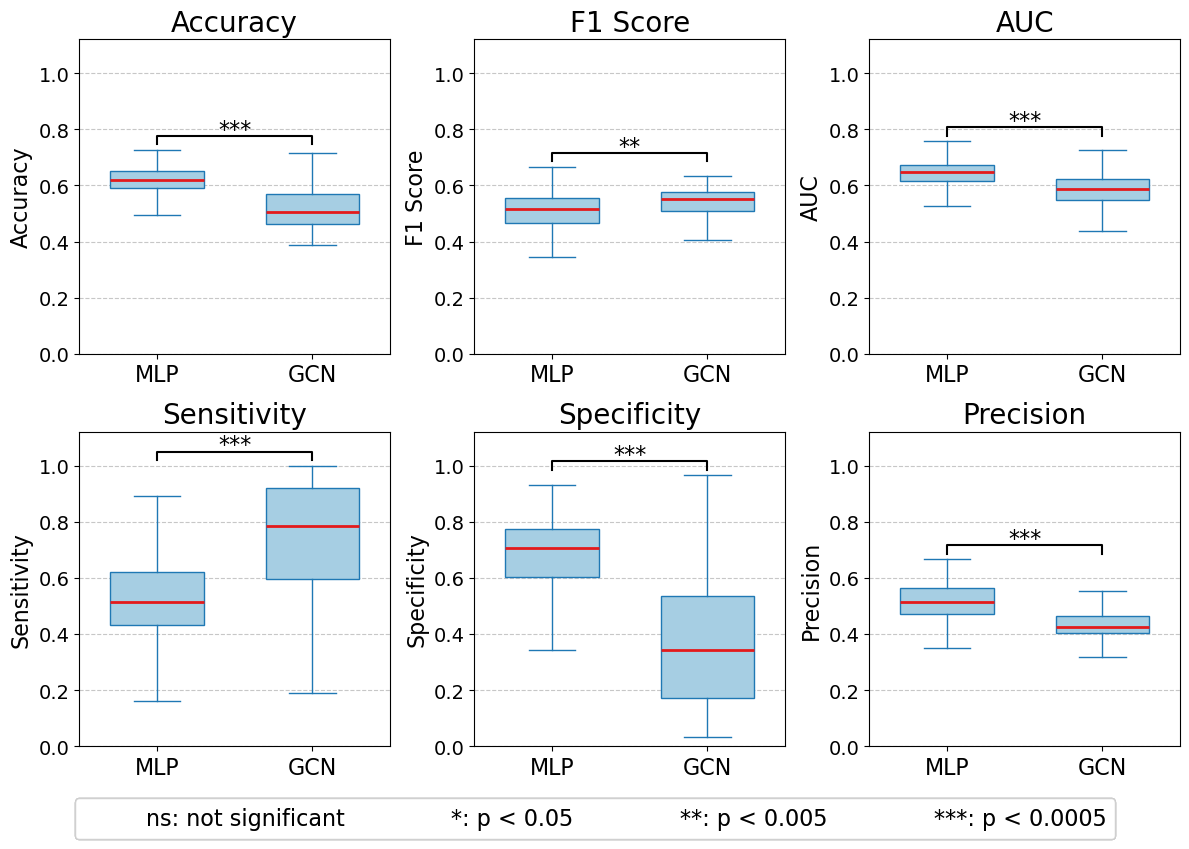

In [35]:
# Load results
with open("MLP_results_V1.pkl", "rb") as f:
    mlp_results = pickle.load(f)
with open("GCN_results_V1.pkl", "rb") as f:
    gcn_results = pickle.load(f)



metrics = [
    ("test_acc_list", "Accuracy"),
    ("test_F1_list", "F1 Score"),
    ("test_auc_list", "AUC"),
    ("test_sens_list", "Sensitivity"),
    ("test_spec_list", "Specificity"),
    ("test_precision_list", "Precision"),
]


p_values = {}
for key, label in metrics:
    stat, p = ttest_rel(mlp_results[key], gcn_results[key])
    p_values[key] = p


def add_significance_bars(ax, group1, group2, p_value, x1, x2, y, significance_level=0.05):
    """Add significance bars to a boxplot."""
    y_offset = 0.03  # Offset for the bar
    ax.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], color='black')
    
    # Annotate with asterisks based on p-value

    if p_value < significance_level / 100:
        ax.text((x1 + x2) / 2, y + y_offset, '***', fontsize=16, ha='center')
    elif p_value < significance_level / 10:
        ax.text((x1 + x2) / 2, y + y_offset, '**', fontsize=16, ha='center')
    elif p_value < significance_level:
        ax.text((x1 + x2) / 2, y + y_offset, '*', fontsize=16, ha='center')
    else:
        ax.text((x1 + x2) / 2, y + y_offset, 'ns', fontsize=16, ha='center')


fig, axs = plt.subplots(2,3, figsize=(12, 8))
axs = axs.flatten()

for idx, (key, label) in enumerate(metrics):
    data = [mlp_results[key], gcn_results[key]]
    bplot = axs[idx].boxplot(
        data,
        patch_artist=True,
        showfliers=False,
        boxprops=dict(facecolor='#a6cee3', color='#1f78b4'),
        medianprops=dict(color='#e31a1c', linewidth=2),
        whiskerprops=dict(color='#1f78b4'),
        capprops=dict(color='#1f78b4'),
        widths=0.6
    )
    
    axs[idx].set_xticklabels(["MLP", "GCN"], fontsize=14)
    axs[idx].set_ylim(0, 1.12)
    axs[idx].set_title(label, fontsize=20)
    axs[idx].set_ylabel(label, fontsize=16)
    axs[idx].tick_params(axis='x', labelsize=16)
    axs[idx].tick_params(axis='y', labelsize=14)
    axs[idx].grid(axis='y', linestyle='--', alpha=0.7)
    y_max = np.max([bplot['whiskers'][i].get_ydata() for i in range(4)])
    add_significance_bars(axs[idx], "MLP", "GCN", p_values[key], 1, 2, y_max + 0.02, significance_level=0.05)

    # Add legend for significance asterisks

    legend_elements = [
        plt.Line2D([0], [0], color='w', marker=None, label='ns: not significant', linestyle=''),
        plt.Line2D([0], [0], color='w', marker=None, label='*: p < 0.05', linestyle=''),
        plt.Line2D([0], [0], color='w', marker=None, label='**: p < 0.005', linestyle=''),
        plt.Line2D([0], [0], color='w', marker=None, label='***: p < 0.0005', linestyle=''),
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=16, frameon=True, bbox_to_anchor=(0.5, -0.07))
plt.tight_layout()
plt.show()

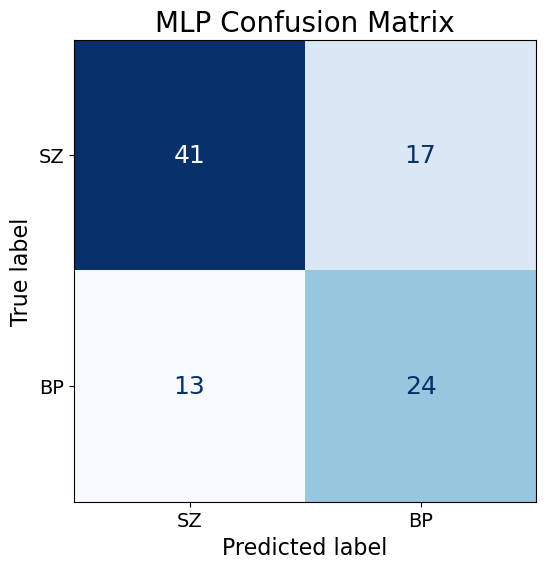

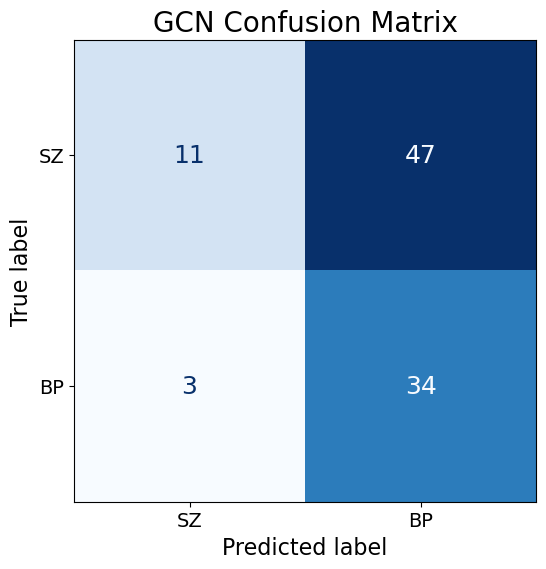

In [52]:
def confusion_matrix_from_sens_spec(sens, spec, n_pos, n_neg):
    """
    Reconstruct confusion matrix from sensitivity, specificity, and class counts.
    Returns: [[TN, FP], [FN, TP]]
    """
    TP = int(round(sens * n_pos))
    FN = n_pos - TP
    TN = int(round(spec * n_neg))
    FP = n_neg - TN
    return np.array([[TN, FP], [FN, TP]])

X_train, X_test, y_train, y_test = train_test_split(fnc_data, targets, test_size=0.2, random_state=42, stratify=targets)
# For MLP
i=0
mlp_sens = mlp_results['test_sens_list'][i]
mlp_spec = mlp_results["test_spec_list"][i]
GCN_sens = gcn_results["test_sens_list"][i]
GCN_spec = gcn_results["test_spec_list"][i]
n_pos = np.count_nonzero(y_test)
n_neg = len(y_test) - n_pos

mlp_cm = confusion_matrix_from_sens_spec(mlp_sens, mlp_spec, n_pos, n_neg)
gcn_cm = confusion_matrix_from_sens_spec(GCN_sens, GCN_spec, n_pos, n_neg)

# Plot MLP confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=mlp_cm, display_labels=['SZ', 'BP'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', colorbar=False, ax=ax)
plt.title("MLP Confusion Matrix", fontsize=20)
ax.set_xlabel("Predicted label", fontsize=16)
ax.set_ylabel("True label", fontsize=16)
ax.tick_params(axis='both', labelsize=14)
for text in disp.text_.ravel():
    text.set_fontsize(18)
plt.show()

# Plot GCN confusion matrix
GCN_confusion_matrix = get_confusion_matrix(graph_model, graph_test_loader, "GCN")
disp = ConfusionMatrixDisplay(confusion_matrix=gcn_cm, display_labels=['SZ', 'BP'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', colorbar=False, ax=ax)
plt.title("GCN Confusion Matrix", fontsize=20)
ax.set_xlabel("Predicted label", fontsize=16)
ax.set_ylabel("True label", fontsize=16)
ax.tick_params(axis='both', labelsize=14)
for text in disp.text_.ravel():
    text.set_fontsize(18)
plt.show()


In [53]:
print(np.median(mlp_results['test_acc_list']))
print(np.median(gcn_results['test_acc_list']))

0.621052622795105
0.5052631497383118
